In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import autograd.numpy as np
from autograd.scipy.special import logsumexp,erf
from autograd.scipy.stats import norm
from autograd import grad

#from autograd_gamma import gamma, gammainc, gammaincc, gammaincln, gammainccln

import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import product
from itertools import combinations
import pickle
import datetime

from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator
from io import StringIO
from Bio import Phylo

from tree import Tree
from optimizer import Optimizer

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

/Users/evsi8432/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_set = "DS1"
pop_size = 5.0 # exponential parameter for constant pop size prior
data_file = '../dat/'+data_set+'/'+data_set+'.pickle'
time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
reparam_file = '../results/'+data_set+'/'+data_set+'_'+time+'_reparam.pickle'
reinforce_file = '../results/'+data_set+'/'+data_set+'_'+time+'_reinforce.pickle'

In [3]:
with open(data_file, 'rb') as f:
    DS1 = pickle.load(f)

In [4]:
genomes = []
species = []
for key in DS1:
    genomes.append(DS1[key])
    species.append(key)
    
n_species = len(species)

In [5]:
# From https://github.com/zcrabbit/vbpi-torch/blob/ff86cf0c47a5753f5cc5b4dfe0b6ed783ab22669/unrooted/phyloModel.py#L7-L11
nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.]}

tree_log_probs = np.array([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = float)
tree_log_probs = np.log(tree_log_probs)

# Set initial $\theta$ using the consesus tree from BEAST

In [6]:
times = 0.05 * np.ones((27,27))

# A Homo-sapiens, mus, rattus, Oryct
times[10,15] = 0.0061
times[10,17] = 0.0093
times[15,19] = 0.0042

# B Trach 23, Alligator 0, Scel 21, Hetero 9, Gallus 6, Turdus 24
times[0,23] = 0.0049
times[9,21] = 0.0072
times[0,9] = 0.0111
times[6,24] = 0.0076
times[6,23] = 0.0203

# C Disco 4, Amph 2, Hypo 12, Grand 8, Ich 13, Pleth 18, Sca 20
times[4,12] = 0.0141
times[2,12] = 0.0082
times[8,12] = 0.0028
times[12,13] = 0.01
times[18,13] = 0.0114
times[18,20] = 0.0052

# D Typh 25, siren 22, Amb 1
times[1,22] = 0.0053
times[1,25] = 0.0098

# E Neso 16, Eleu 5, Gatro 7, Hyla 11, Bufo 3
times[5,16] = 0.0138
times[5,7] = 0.0175
times[3,11] = 0.0157
times[3,16] = 0.0207

# A B
times[10,23] = 0.0312

# C D
times[4,22] = 0.0165

# CDE
times[5,22] = 0.0229

# CDE Xeno 26 Lat 14
times[5,26] = 0.0278
times[5,14] = 0.0348

# ABCDE
times[5,10] = 0.0406

In [7]:
theta = np.zeros((2,n_species,n_species))
log_times = np.log(times)

tree = Tree(theta,log_times,tree_log_probs,
            pop_size=pop_size)

for node in tree.nodes:
    combs = combinations(node.leaves,2)
    for inds in combs:
        inds = sorted(inds)
        theta[0,inds[1],inds[0]] = min(theta[0,inds[1],inds[0]],np.log(node.coal_time))
        theta[1,inds[1],inds[0]] = -2
        
print(theta.shape)

(2, 27, 27)


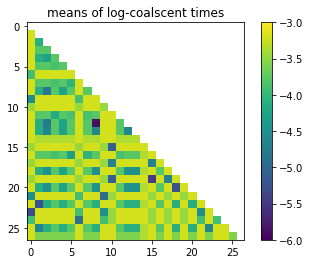

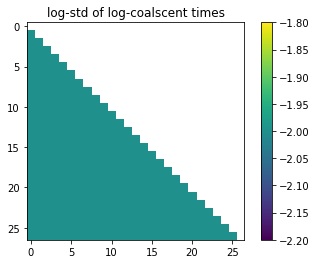

In [8]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m,vmin = -6, vmax = -3)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

# Set initial $\theta$ using expected number of changes

In [9]:
times = np.zeros((n_species,n_species))

for i in range(n_species):
    for j in range(n_species):
        eq = [x != y for x,y in zip(genomes[i],genomes[j]) if ((x in ["A","C","T","G"]) and (y in ["A","C","T","G"]))]
        p_hat = np.mean(eq)
        
        times[i,j] = np.mean(eq)

In [10]:
log_times = np.log(times)

log_times[np.triu_indices(log_times.shape[0])] = np.inf

tree = Tree(theta,log_times,tree_log_probs,
            pop_size=pop_size)

theta = np.zeros((2,n_species,n_species))

for node in tree.nodes:
    combs = combinations(node.leaves,2)
    for inds in combs:
        inds = sorted(inds)
        theta[0,inds[1],inds[0]] = min(theta[0,inds[1],inds[0]],np.log(node.coal_time))
        theta[1,inds[1],inds[0]] = -2
        
print(theta.shape)

(2, 27, 27)


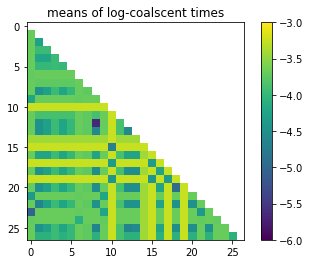

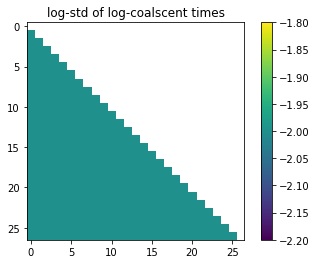

In [11]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m,vmin = -6, vmax = -3)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

# Make Neighbor Joining initial guess

In [12]:
times = np.zeros((n_species,n_species))

for i in range(n_species):
    for j in range(n_species):
        eq = [x != y for x,y in zip(genomes[i],genomes[j]) if ((x in ["A","C","T","G"]) and (y in ["A","C","T","G"]))]
        p_hat = np.mean(eq)
        
        times[i,j] = np.mean(eq)

matrix = []
for i,row in enumerate(times):
    matrix.append(list(row[:(i+1)]))
m = _DistanceMatrix(species, matrix)
calculator = DistanceCalculator('identity')
constructor = DistanceTreeConstructor(calculator, 'nj')
tree = constructor.nj(m)

theta = np.zeros((2,n_species,n_species))
for i in range(n_species):
    for j in range(i):
        theta[0,i,j] = np.log(tree.distance(target1=species[i],target2=species[j]))
        theta[1,i,j] = -2

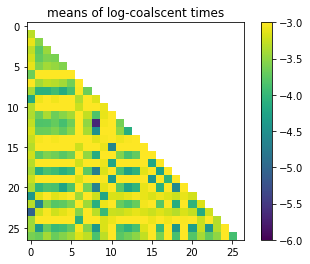

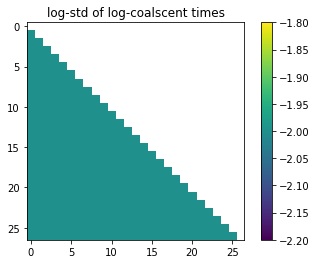

In [13]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m,vmin = -6, vmax = -3)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

# perform variational inference

In [15]:
optim_reparam = Optimizer(tree_log_probs,deepcopy(theta))

optim_reparam.optimize_q_reparam(batch_size=10,
                                 iters=1000,
                                 alphas=[0.01,0.01],
                                 record_every=10,
                                 test_batch_size=100,
                                 pop_size=pop_size)

iteration:  0
runtime: 0 mins
grad_norm estimate:  73.74216828932873
ELBO estimate:  -7492.211541905569

iteration:  10
runtime: 0 mins
grad_norm estimate:  57.38516103310947
ELBO estimate:  -7406.764256276947

iteration:  20
runtime: 1 mins
grad_norm estimate:  54.76383513223381
ELBO estimate:  -7348.7421189575725

iteration:  30
runtime: 2 mins
grad_norm estimate:  38.763032113930635
ELBO estimate:  -7311.102853695533

iteration:  40
runtime: 2 mins
grad_norm estimate:  51.21319201215057
ELBO estimate:  -7284.066505476009

iteration:  50
runtime: 3 mins
grad_norm estimate:  75.40111039008781
ELBO estimate:  -7264.343525705075

iteration:  60
runtime: 4 mins
grad_norm estimate:  34.5516156984691
ELBO estimate:  -7245.224126657613

iteration:  70
runtime: 4 mins
grad_norm estimate:  159.35741265656756
ELBO estimate:  -7230.016024754163

iteration:  80
runtime: 5 mins
grad_norm estimate:  70.85262448266835
ELBO estimate:  -7228.420470242149

iteration:  90
runtime: 6 mins
grad_norm esti

KeyboardInterrupt: 

In [ ]:
plt.plot(optim_reparam.ELBO_ests)
plt.show()
plt.plot(np.log(optim_reparam.grad_norms))
plt.show()

m = deepcopy(optim_reparam.theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_reparam.theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

In [13]:
with open(reparam_file, 'wb') as file: 
    pickle.dump(optim_reparam, file) 

In [ ]:
optim_reinforce = Optimizer(tree_log_probs,deepcopy(theta))

optim_reinforce.optimize_q_reinforce(batch_size=100,
                                     iters=100,
                                     alphas=[0.01,0.01],
                                     record_every=10,
                                     test_batch_size=100,
                                     pop_size=pop_size)

In [ ]:
plt.plot(optim_reinforce.ELBO_ests)
plt.show()
plt.plot(np.log(optim_reinforce.grad_norms))
plt.show()

m = deepcopy(optim_reinforce.theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_reinforce.theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

In [ ]:
with open(reinforce_file, 'wb') as file: 
    pickle.dump(optim_reinforce, file) 

In [17]:
optim_VIMCO = Optimizer(tree_log_probs,deepcopy(optim_reparam.theta))

optim_VIMCO.optimize_q_VIMCO(batch_size=10,
                             iters=100,
                             alphas=[0.01,0.01],
                             record_every=10,
                             test_batch_size=100,
                             pop_size=pop_size)

iteration:  0
runtime: 0 mins
grad_norm estimate:  102046.16890504611
ELBO estimate:  -7160.954024653366

iteration:  10
runtime: 0 mins
grad_norm estimate:  115956.14686668382
ELBO estimate:  -7166.685158670378

iteration:  20
runtime: 1 mins
grad_norm estimate:  113620.9003579098
ELBO estimate:  -7167.288195649325

iteration:  30
runtime: 1 mins
grad_norm estimate:  127220.41823086576
ELBO estimate:  -7169.47345412039

iteration:  40
runtime: 1 mins
grad_norm estimate:  123424.44958536494
ELBO estimate:  -7170.6449637432015

iteration:  50
runtime: 2 mins
grad_norm estimate:  92242.91281426465
ELBO estimate:  -7173.405011984285

iteration:  60
runtime: 2 mins
grad_norm estimate:  125290.2660823859
ELBO estimate:  -7175.128704049933

iteration:  70
runtime: 3 mins
grad_norm estimate:  164912.83583531552
ELBO estimate:  -7179.180293439837

iteration:  80
runtime: 4 mins
grad_norm estimate:  126703.5085703102
ELBO estimate:  -7181.392754296915

iteration:  90
runtime: 4 mins
grad_norm e

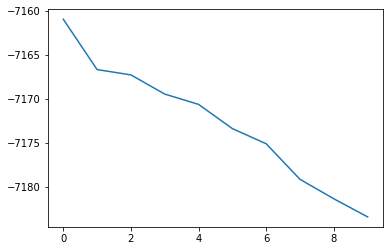

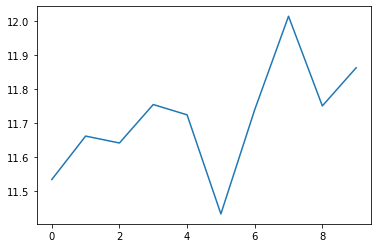

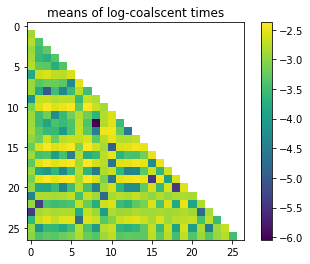

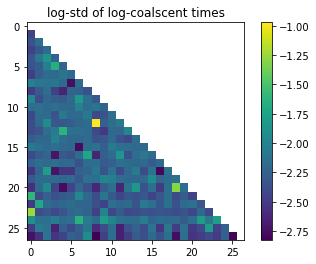

In [18]:
plt.plot(optim_VIMCO.ELBO_ests)
plt.show()
plt.plot(np.log(optim_VIMCO.grad_norms))
plt.show()

m = deepcopy(optim_VIMCO.theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_VIMCO.theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

In [ ]:
optim = optim_reinforce
theta = optim.theta

# draw the random tree using a newick file

In [ ]:
for _ in range(10):
    Z = np.random.normal(np.ones_like(theta[0]))
    log_times = np.exp(theta[1])*Z+theta[0]
    log_times = log_times + np.triu(np.ones_like(theta[0])*np.inf)

    tree = Tree(theta,log_times,tree_log_probs,
                pop_size=pop_size)

    def write_newick(node):

        if node.children == []:
            return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time)
        elif node.parent is None:
            return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
        else:
            bl = node.parent.coal_time - node.coal_time
            return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)


    treedata = write_newick(tree.nodes[-1])
    handle = StringIO(treedata)
    tree_to_draw = Phylo.read(handle, "newick")

    # Set up the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Draw the phylogenetic tree
    Phylo.draw(tree_to_draw, axes=ax)

    print(tree.log_like)
    print(tree.log_prior)
    print(tree.log_p)

# Estimate the marginal likelihood

In [ ]:
n_exp = 10
n_samples = 1000

# get priors and log-liklihoods
priors = []
LL = []

# get log_qs
log_qs = []

# get root heights
rootHeights = []

# get tree topologies
tree_hash = {}
top_counts = {}

# get marginal log-likelihoods and ELBOs
MLL_all = np.zeros(n_exp)
ELBO_all = np.zeros(n_exp)

for i in range(n_exp):
    
    print(i)
    MLL = np.zeros(n_samples)
    ELBO = np.zeros(n_samples)
    Zs = np.random.normal(size=(n_samples,n_species,n_species))

    for j,Z in enumerate(Zs):
        log_times = np.exp(theta[1])*Z+theta[0]
        log_times = log_times + np.triu(np.full(n_species, np.inf))
        tree = Tree(optim.theta,log_times,deepcopy(tree_log_probs),
                    pop_size=pop_size)
        
        MLL[j] = tree.log_p - tree.log_q
        ELBO[j] = tree.log_p - tree.log_q
        
        LL.append(tree.log_like)
        priors.append(tree.log_prior)
        log_qs.append(tree.log_q)
        rootHeights.append(tree.nodes[-1].coal_time)
        
        tree_top = frozenset([frozenset(x.leaves) for x in tree.nodes])
        if tree_top in tree_hash:
            top_counts[tree_hash[tree_top]] += 1
        else:
            tree_hash[tree_top] = len(tree_hash)
            top_counts[tree_hash[tree_top]] = 1
        
    MLL_all[i] = logsumexp(MLL) - np.log(n_samples)
    ELBO_all[i] = np.mean(ELBO)

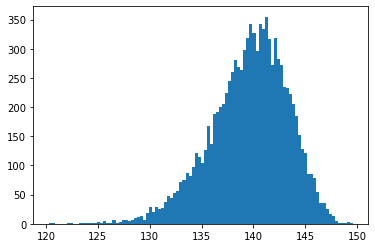

139.58910329986853


In [23]:
plt.hist(log_qs,bins = 100)
plt.show()
print(np.mean(log_qs))

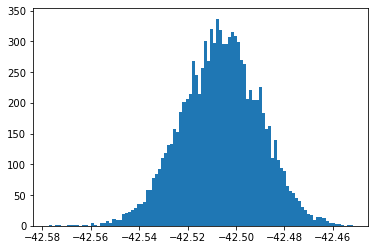

-42.50641210175989


In [24]:
plt.hist(priors,bins = 100)
plt.show()
print(np.mean(priors))

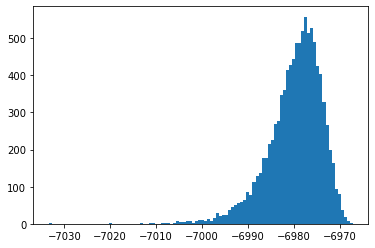

-6979.78460263541


In [25]:
plt.hist(LL,bins = 100)
plt.show()
print(np.mean(LL))

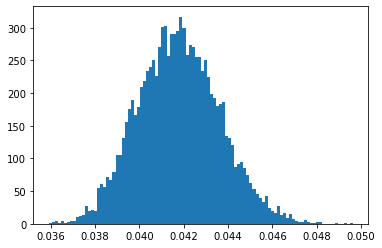

0.041778539288600126


In [26]:
plt.hist(rootHeights,bins = 100)
plt.show()
print(np.mean(rootHeights))

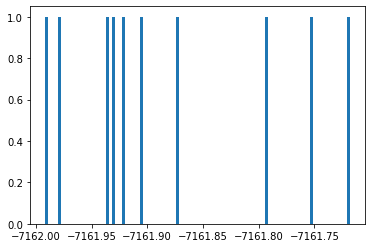

-7161.880118037038


In [27]:
plt.hist(ELBO_all,bins = 100)
plt.show()
print(np.mean(ELBO_all))

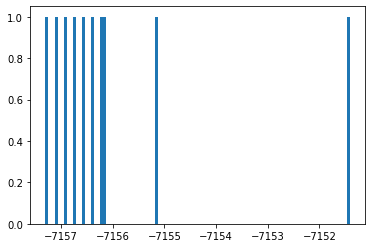

-7155.9975135274235


In [28]:
plt.hist(MLL_all,bins = 100)
plt.show()
print(np.mean(MLL_all))

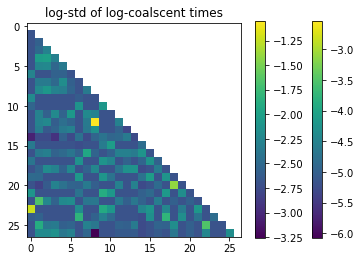

In [29]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()

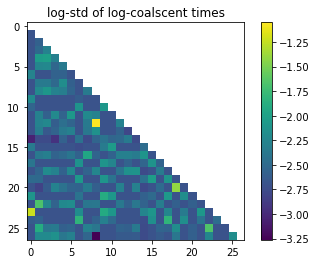

In [30]:
log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()